## 实验要求:

### 1. 数据分析、统计

1.  单个特征的分布
2.  统计缺失值
3.  特征间的相关性
4.  推测特征的含义
5.  异常样本
6.  数据抽样

### 2. 特征抽取

1.  特征的变换,如 str 转 int,取 log
2.  尝试组合特征
3.  特征子集选择


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
%matplotlib inline
sns.set_context("paper")  
sns.set(rc={'figure.figsize': (10, 8)})  # 设置画板大小
sns.set_style('whitegrid')

In [2]:
raw_path = "data/pica2015.csv"
cleaned_path = "data/pica2015_cleaned.csv"

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

## Below is data cleaning process

Include:

1. use mode data to fill the NaN
2. turn `str` and `object` to `int` or `float`
3. drop columns with the same data which means they are unrelated to the classification result
4. do MinMaxscaler to take all the data in [0,1]

Cleaned data has been loaded into "data/pica2015_cleaned.csv"


In [ ]:
df = pd.read_csv(raw_path)

In [5]:
# actually, we can see from the codebook that columns[5:19] are unrelated to the target variable
# so we can drop them
df.drop(columns=df.columns[5:19], inplace=True)

In [6]:
# feature type transformation

# temporarily turn nan to -1 for type conversion
df.replace(' ', -1, inplace=True)
# turn column[3] to str
df.iloc[:, 3] = df.iloc[:, 3].astype(str)
# turn the q part to `int`
df.iloc[:, 7:231] = df.iloc[:, 7:231].astype(int)
# turn the v part to `float`
df.iloc[:, 231:-1] = df.iloc[:, 231:-1].astype(float)
# actually null values are ' ' (space), need to change to NaN
df.replace(-1, np.nan, inplace=True)

In [7]:
# process missing data which is xx9
# turn them into np.nan

max_list = []
for i in range(len(df.columns)):
	ele = df.iloc[:, i].max()
	max_list.append(ele)
for i in range(len(df.columns)):
	if max_list[i] in [9,99,98,998,999,9.0,99.0,98.0,998.0,999.0,95.0]:
		df.iloc[:, i].replace(max_list[i], np.nan, inplace=True)

In [8]:
# search all the column name with null values
null_columns = df.columns[df.isnull().any()]
# count the number of null values in each column, see those who have more than 10% null value
df[null_columns].isnull().sum()>3000
# actually those who have more than 10% null value are not meaningless, we can neglect them

ST005Q01TA    False
ST006Q01TA     True
ST006Q02TA     True
ST006Q03TA     True
ST007Q01TA    False
ST008Q01TA     True
ST008Q02TA     True
ST008Q03TA     True
ST011Q01TA    False
ST011Q02TA    False
ST011Q03TA    False
ST011Q04TA    False
ST011Q05TA    False
ST011Q06TA    False
ST011Q07TA    False
ST011Q08TA    False
ST011Q09TA    False
ST011Q10TA    False
ST011Q11TA    False
ST011Q12TA    False
ST011Q16NA    False
ST011D17TA    False
ST011D18TA    False
ST011D19TA    False
ST012Q01TA    False
ST012Q02TA    False
ST012Q03TA    False
ST012Q05NA    False
ST012Q06NA    False
ST012Q07NA    False
ST012Q08NA    False
ST012Q09NA    False
ST013Q01TA    False
ST123Q01NA    False
ST123Q02NA    False
ST123Q03NA    False
ST123Q04NA    False
ST019AQ01T    False
ST019BQ01T    False
ST019CQ01T    False
ST021Q01TA    False
ST022Q01TA    False
ST125Q01NA    False
ST126Q01TA    False
ST127Q01TA    False
ST127Q02TA    False
ST111Q01TA    False
ST118Q01NA    False
ST118Q02NA    False
ST118Q03NA    False


In [9]:
# fill the null values with the mode of the column
mode_dict = df[null_columns].mode().iloc[0].astype(int).to_dict()
df.fillna(mode_dict, inplace=True)

<AxesSubplot:ylabel='ST004D01T'>

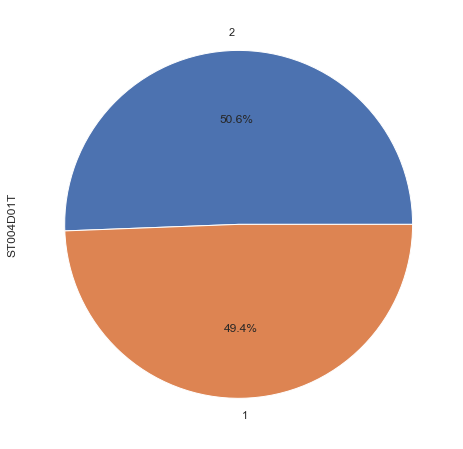

In [10]:
# see the distribution of gender
gender = df['ST004D01T'].value_counts()
gender.plot(kind='pie', autopct='%1.1f%%')

In [11]:
# samely see the distribution of df.columns[1:10]
# they are all uniformly distributed, therefore meaningless
# delete these columns
df.drop(columns=df.columns[1:11], inplace=True)

In [12]:
# use MinMaxScaler to normalize the data
df_scaled_np = MinMaxScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled_np, columns=df.columns)

In [13]:
# save df to cleaned_path
# df_scaled.to_csv(cleaned_path, index=False)

In [14]:
# Below is to see the corresponding meaning of each columns and save to dicts,
# which will give great convenience when I want to refer the meaning of each feature.
cb = pd.read_excel('data/codebook.xlsx')
cb.NAME = cb.NAME.astype(str)
cb.drop(index = cb[cb.NAME=='nan'].index, inplace=True)
col = df.columns.to_numpy()
name = cb.NAME.to_numpy()
zai = []
for i in range(len(name)):
    if name[i] in col:
        zai.append(False)
    else:
        zai.append(True)
cb.drop(index = cb[zai].index, inplace=True)
# load cb's "NAME" and "VARLABEL" to a dict
cb_dict = cb.set_index('NAME').VARLABEL.to_dict()
# load cb_dict to "data/dictionary_cleaned.txt"
cb_dict_path = "data/dictionary_cleaned.txt"
# f = open(cb_dict_path, 'w')
# f.write(json.dumps(cb_dict, indent=0))

## Clean `finished`

## Below are done on cleaned data.


### 1. Prepare data and tool function.


In [15]:
df = pd.read_csv(cleaned_path)

<AxesSubplot:ylabel='REPEAT'>

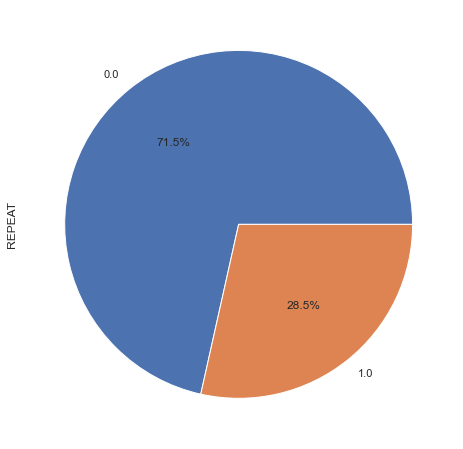

In [16]:
# first, see the distribution of `REPEAT`
rpt = df['REPEAT'].value_counts()
rpt.plot(kind='pie', autopct='%1.1f%%')

In [17]:
# extract the data of `REPEAT`
final_rpt = pd.DataFrame(df['REPEAT'], columns=['REPEAT'])
final_rpt_np = final_rpt.to_numpy()

In [18]:
# make new dataframe from old dataframe according to index_list
def turn_to_list(str):
	begin, end = str.split('~')
	list = [int(i) for i in range(int(begin), int(end)+1)]
	return list

def make_df(df, index_list, add_repeat = False):
	df_new = pd.DataFrame()
	for i in range(len(index_list)):
		index = index_list[i]
		if(type(index) == int):
			col = df.columns[index]
		else:
			col = index
		df_new[col] = df[col]
	if(add_repeat):
		df_new['REPEAT'] = df['REPEAT']
	return df_new

In [19]:
# simple sum
def sum(df,name,mean = False):
	if(df.columns[-1] == 'REPEAT'):
		df.drop(columns=['REPEAT'], inplace=True)
	if(type(df) == pd.core.frame.DataFrame):
		df = df.to_numpy()
	long = len(df[0])
	df = np.sum(df, axis=1)
	if(mean):
		df = df/long
	df = pd.DataFrame(df, columns=[name])
	return df

In [20]:
# sum all the features with relation to `REPEAT` and standardlize the value
def sum_stdlz(map, df, name):
	if(type(df) == pd.core.frame.DataFrame):
		df = df.to_numpy()
	scaler = MinMaxScaler()
	pn = map.iloc[-2]
	sign = map.iloc[-1][0]
	for i in range(len(pn)-1):
		if(i==0):
			if(sign>0):
				temp = df[:,i]
			else:
				temp = -df[:,i]
		else:
			if ((pn[i]>0 and sign > 0)or(pn[i]<0 and sign < 0)):
				temp = temp + df[:,i]
			else:
				temp = temp - df[:,i]
	df_new = scaler.fit_transform(temp.reshape(-1,1))
	df_new_pd = pd.DataFrame(df_new).rename(columns={0: name})
	return df_new_pd

In [21]:
# draw corr hot map
def draw_corr_map(df,method='pearson'):
	map = df.corr(method=method)
	sns.heatmap(map, annot=True, cmap='coolwarm')
	return map

### 2. divide the features into several parts by hand

parent education: "n" 11 16 PENT_EDU

study environment: "01" 11 13~16 20 21 STDY_EVNRMNT

life quality:"01" 12 18 19 23-26 "n" 27-35 LF_QLTY

parent care: "01" 36-39 PRNT_CR

former rpt: "01" 48-50 EC_RPT

study : "n": 52-54 "01":55 56 "01" 57-64 STY

peer: "01": 73-78 PEER

tchr: "01": 79-84 TCHR

skip: "01": 90-92 SKIP

class phenonmenon: 116-120， 121-129，130-146 CLS1,2,3

knowledge: "n": 304-403 KNLDG


#### 2.1 PRNT_EDU

In [22]:
def plt_pie(df, index):
    x = df[df.columns[index]].value_counts()
    x.plot(kind='pie', autopct='%1.1f%%')

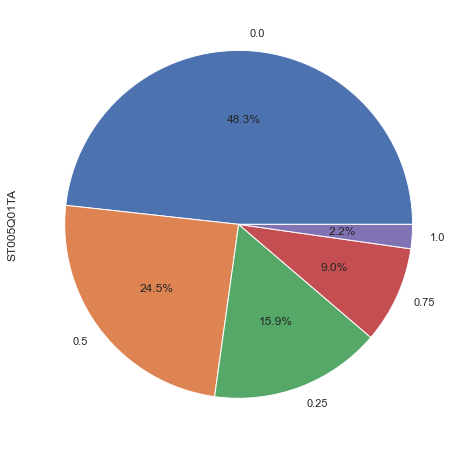

In [23]:
plt_pie(df, 1)

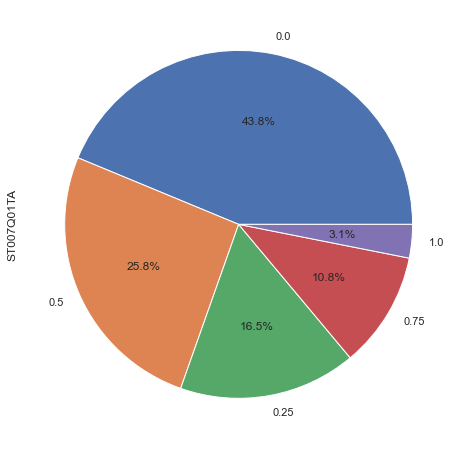

In [24]:
plt_pie(df, 6)

In [25]:
# we can see observe that the distribution of father and mother's education
# level is very similar, so we can mix them to form a new one
prnt_edu_pd = make_df(df,[1,2,3,4,5,6,7,8,9,10])
prnt_edu_np = prnt_edu_pd.to_numpy()
prnt_edu = prnt_edu_np[:,0] - prnt_edu_np[:,1] - 0.75 * prnt_edu_np[:,2] - 0.5 * prnt_edu_np[:,3] - 0.25 * prnt_edu_np[:,4]\
    + prnt_edu_np[:,5] - prnt_edu_np[:,6] - 0.75 * prnt_edu_np[:,7] - 0.5 * prnt_edu_np[:,8] - 0.25 * prnt_edu_np[:,9]
PRNT_EDU = pd.DataFrame(-prnt_edu, columns=['PRNT_EDU'])

In [26]:
prnt_edu_r = pd.concat([df['REPEAT'], PRNT_EDU], axis=1)

<AxesSubplot:xlabel='REPEAT', ylabel='PRNT_EDU'>

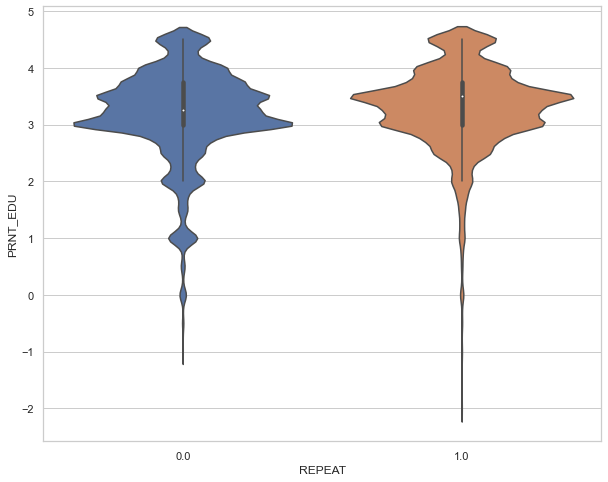

In [27]:
sns.violinplot(x='REPEAT', y='PRNT_EDU', data=prnt_edu_r)

Violinplot is a special type of boxplot, which can reveal the quantity density

#### 2.2 STDY_EVNRMNT

In [28]:
stdy_evrnmt_pd = make_df(df, [11] + turn_to_list('13~16') + [20,21])

In [29]:
stdy_evrnmt_np = stdy_evrnmt_pd.to_numpy()
stdy_evrnmt_np = np.sum(stdy_evrnmt_np, axis=1)
STDY_EVNRNMNT = pd.DataFrame(stdy_evrnmt_np, columns=['STDY_EVNRNMNT'])

In [30]:
stdy_evrnmt_r = pd.concat([df['REPEAT'], STDY_EVNRNMNT], axis=1)

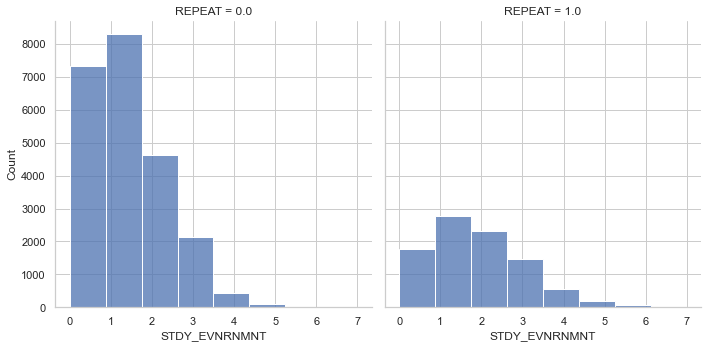

In [31]:
sns.displot(data = stdy_evrnmt_r, x='STDY_EVNRNMNT',bins=8,col='REPEAT')

Displot group by the value of 'col'

#### 2.3 LF_QLTY


In [32]:
lf_qlty_pd = make_df(df, [12,18,19] + turn_to_list('23~26') + turn_to_list('27~35'))

In [33]:
lf_qlty_np = lf_qlty_pd.to_numpy()
lf_qlty_np = np.sum(lf_qlty_np, axis=1)
LF_QLTY = pd.DataFrame(lf_qlty_np, columns=['LF_QLTY'])

In [34]:
lf_qlty_r = pd.concat([df['REPEAT'], LF_QLTY], axis=1)

<AxesSubplot:xlabel='LF_QLTY', ylabel='Count'>

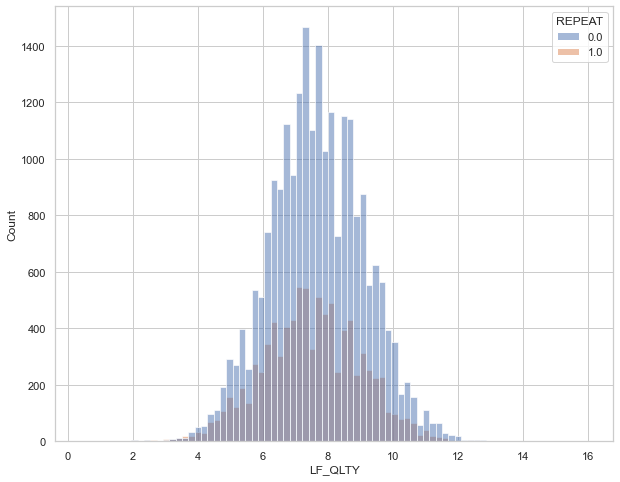

In [35]:
sns.histplot(data = lf_qlty_r, x='LF_QLTY',bins=80, hue='REPEAT')

Displot group by the value of 'hue'

#### 2.4 PRNT_CR

In [36]:
prnt_cr_pd = make_df(df, turn_to_list('36~39'), add_repeat=True)

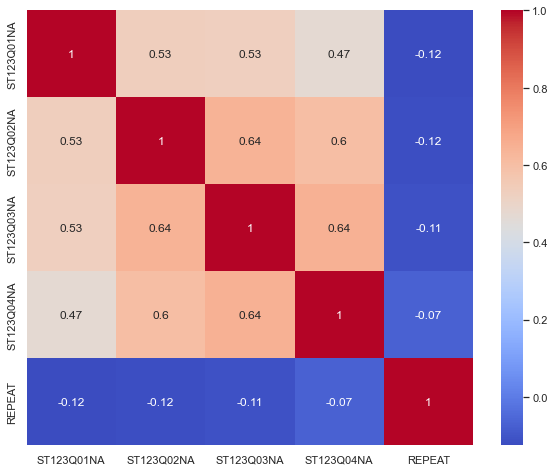

In [37]:
map = draw_corr_map(prnt_cr_pd)

In [38]:
PRNT_CR = sum(prnt_cr_pd, 'PRNT_CR')

<AxesSubplot:xlabel='REPEAT', ylabel='PRNT_CR'>

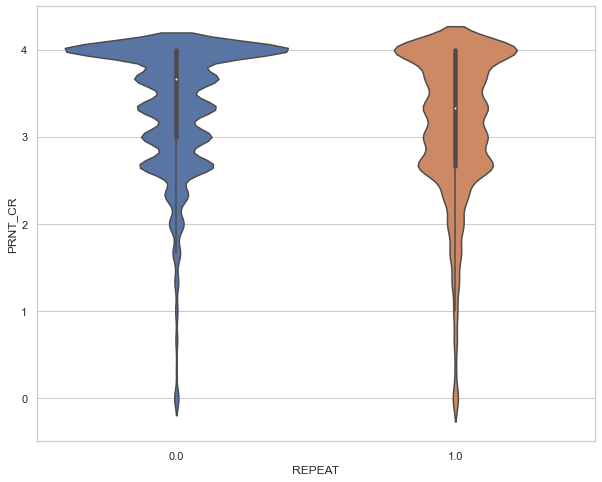

In [39]:
prnt_cr_r = pd.concat([df['REPEAT'], PRNT_CR], axis=1)
sns.violinplot(x='REPEAT', y='PRNT_CR', data=prnt_cr_r)
# sns.histplot(data = prnt_cr_r, x='PRNT_CR',bins=13, hue='REPEAT')

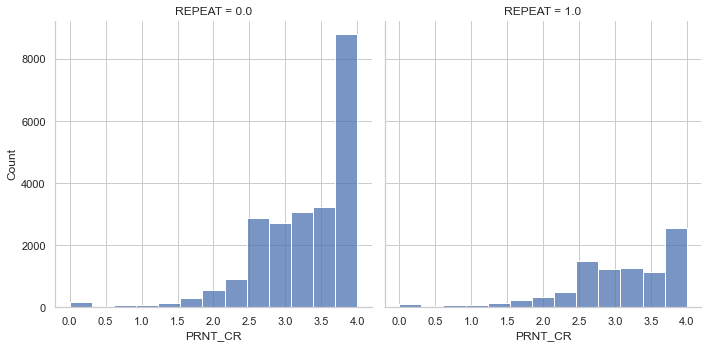

In [40]:
sns.displot(data = prnt_cr_r, x='PRNT_CR',bins=13, col='REPEAT')

#### 2.5 EX_RPT


In [41]:
ex_rpt_pd = make_df(df, [48,49,50])

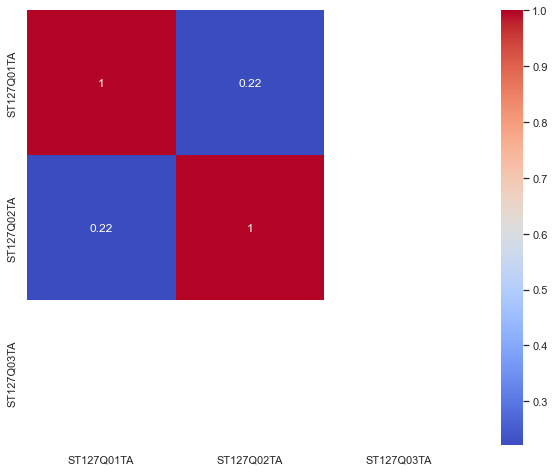

In [42]:
map = draw_corr_map(ex_rpt_pd)

In [43]:
# check the codebook
# 7 means "no answer"
# I guess that the students haven't reached level 3, therefore it's explained.

In [44]:
ex_rpt_pd = make_df(df, [48,49])

In [45]:
ex_rpt_np = ex_rpt_pd.to_numpy()
ex_rpt_np = np.sum(ex_rpt_np, axis=1)
EX_RPT = pd.DataFrame(ex_rpt_np, columns=['EX_RPT'])

In [46]:
ex_rpt_r = pd.concat([df['REPEAT'], EX_RPT], axis=1)

,REPEAT,EX_RPT
REPEAT,1.00000,0.91077
EX_RPT,0.91077,1.00000


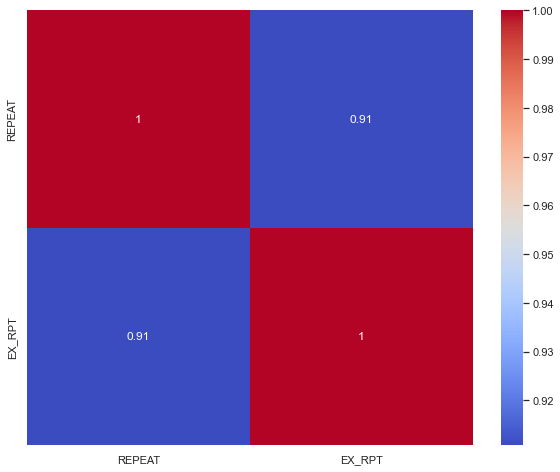

In [47]:
draw_corr_map(ex_rpt_r)

Corr and Heatmap

#### 2.6 STY

In [48]:
sty_pd = make_df(df, turn_to_list('52~64'), add_repeat = True)

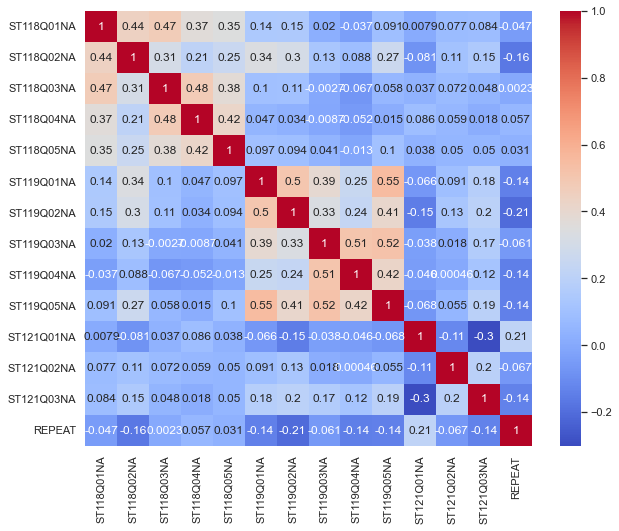

In [49]:
map = draw_corr_map(sty_pd)

In [50]:
STY = sum_stdlz(map, sty_pd, 'STY')

In [51]:
sty_r = pd.concat([df['REPEAT'], STY], axis=1)

<AxesSubplot:xlabel='STY', ylabel='Count'>

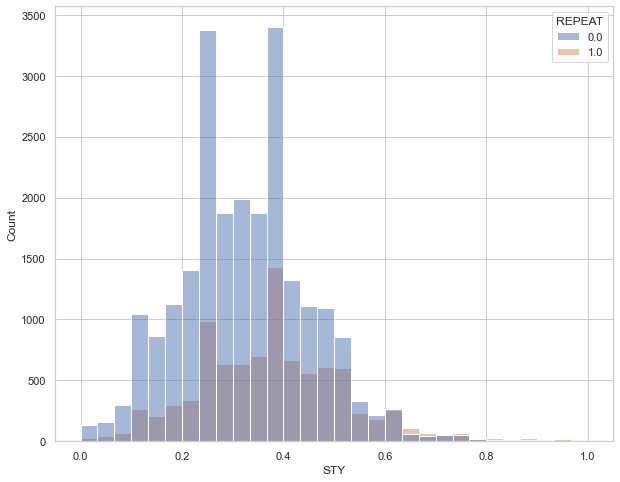

In [52]:
sns.histplot(data = sty_r, x='STY',bins=30, hue='REPEAT')

Heatmap + Histplot

#### 2.7 PEER

In [53]:
peer_pd = make_df(df, turn_to_list('73~78'), add_repeat = True)

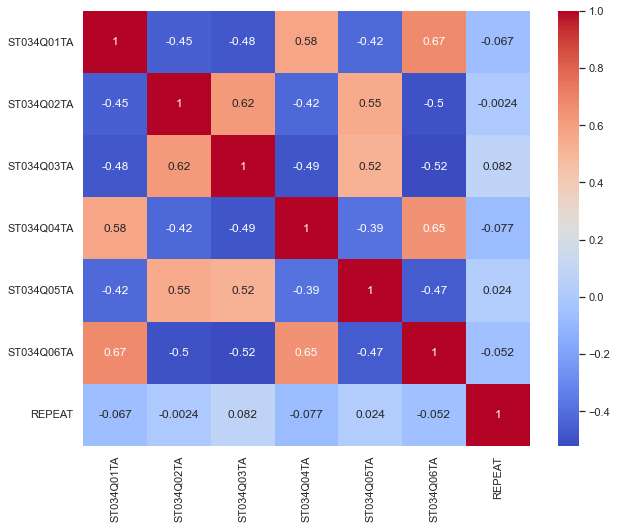

In [54]:
map = draw_corr_map(peer_pd, method='pearson')

In [55]:
PEER = sum_stdlz(map, peer_pd, 'PEER')

<AxesSubplot:xlabel='PEER', ylabel='Count'>

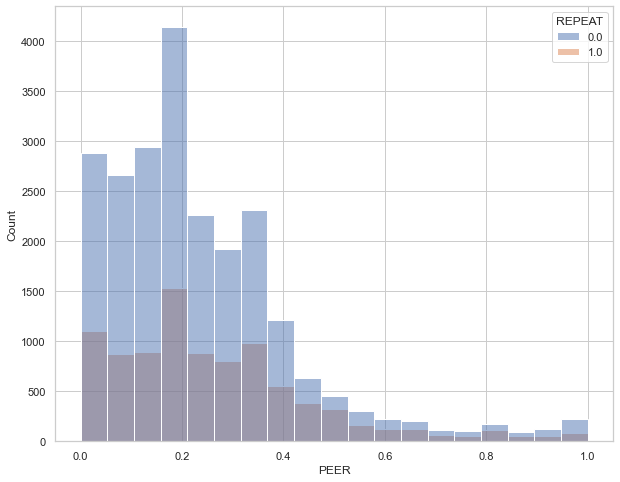

In [56]:
peer_r = pd.concat([df['REPEAT'], PEER], axis=1)
sns.histplot(data = peer_r, x='PEER',bins=19, hue='REPEAT')

#### 2.8 TCHR

In [57]:
tchr_pd = make_df(df, turn_to_list('79~84'), add_repeat = True)

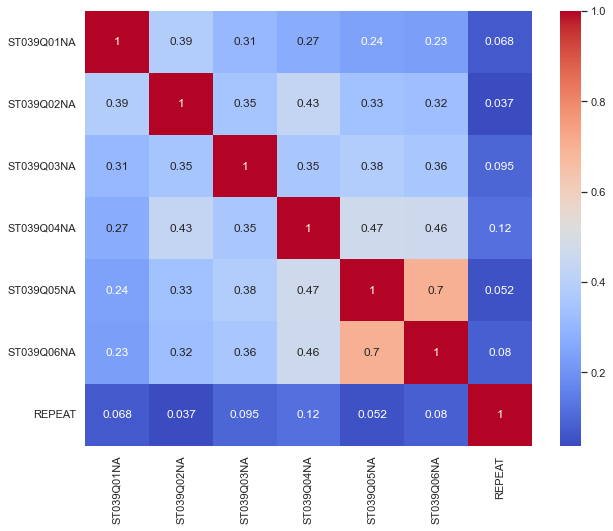

In [58]:
map = draw_corr_map(tchr_pd, method='pearson')

In [59]:
TCHR = sum_stdlz(map, tchr_pd, 'TCHR')

<AxesSubplot:xlabel='REPEAT', ylabel='TCHR'>

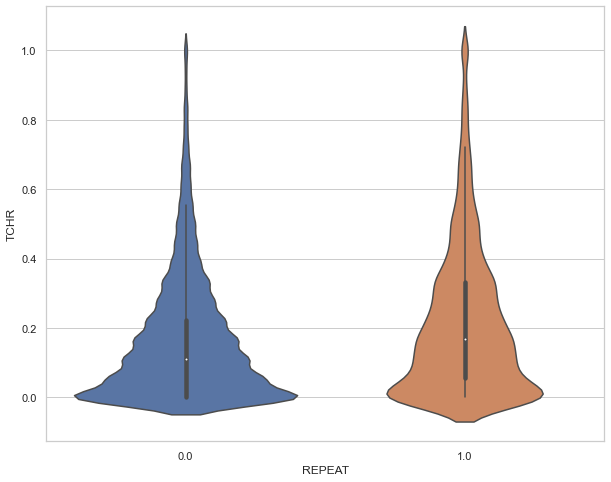

In [60]:
tchr_r = pd.concat([df['REPEAT'], TCHR], axis=1)
sns.violinplot(x='REPEAT', y='TCHR', data=tchr_r)

#### 2.9 SKIP

In [61]:
skip_pd = make_df(df, turn_to_list('90~92'), add_repeat = True)

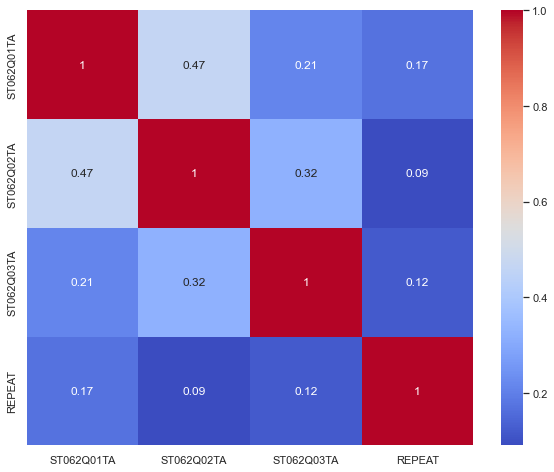

In [62]:
map = draw_corr_map(skip_pd, method='pearson')

In [63]:
SKIP = sum_stdlz(map, skip_pd, 'SKIP')

<AxesSubplot:xlabel='SKIP', ylabel='Count'>

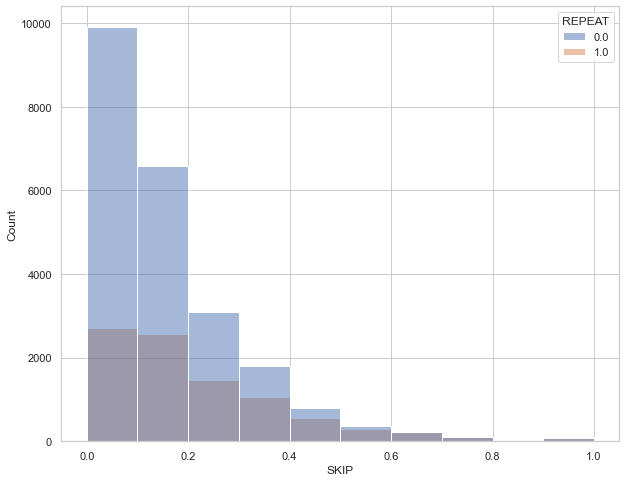

In [64]:
skip_r = pd.concat([df['REPEAT'], SKIP], axis=1)
sns.histplot(data = skip_r, x='SKIP',bins=10, hue='REPEAT')

#### 2.10.1 CLS1

In [65]:
cls1_pd = make_df(df, turn_to_list('116~120'), add_repeat = True)

In [66]:
CLS1 = sum(cls1_pd, 'CLS1')

<AxesSubplot:xlabel='CLS1', ylabel='Count'>

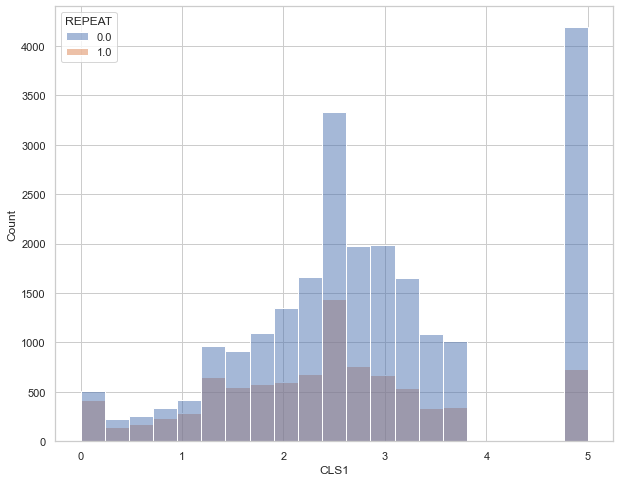

In [67]:
cls1_r = pd.concat([df['REPEAT'], CLS1], axis=1)
sns.histplot(data = cls1_r, x='CLS1',bins=21, hue='REPEAT')

the higher, the greater the class phenomenon is

#### 2.10.2 CLS2

In [68]:
cls2_pd = make_df(df, turn_to_list('121~129'), add_repeat = True)

In [69]:
CLS2 = sum(cls2_pd, 'CLS2')

<AxesSubplot:xlabel='CLS2', ylabel='Count'>

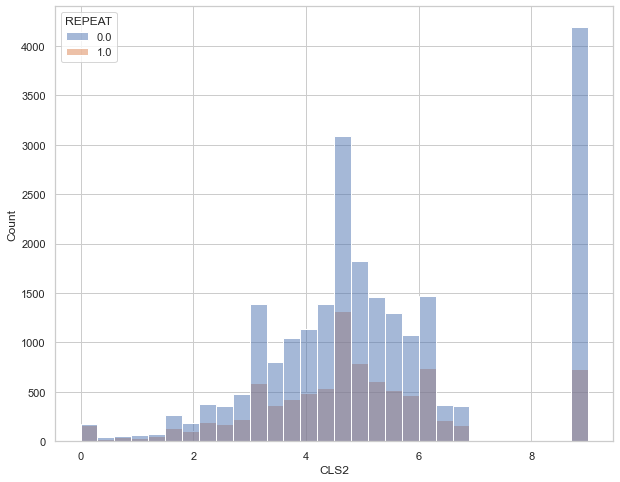

In [70]:
cls2_r = pd.concat([df['REPEAT'], CLS2], axis=1)
sns.histplot(data = cls2_r, x='CLS2',bins=30,hue='REPEAT')

#### 2.10.3 CLS3

In [71]:
cls3_pd = make_df(df, turn_to_list('130~146'), add_repeat = True)

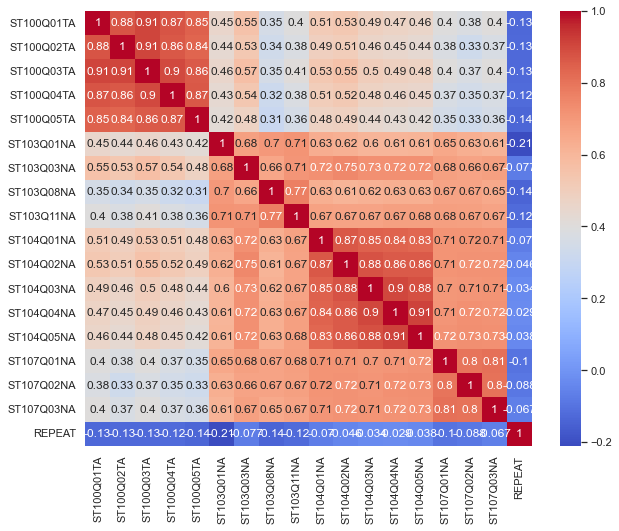

In [72]:
map = draw_corr_map(cls3_pd, method='pearson')

In [73]:
CLS3 = sum(cls3_pd, 'CLS3')

In [74]:
cls3_r = pd.concat([df['REPEAT'], CLS3], axis=1)

<AxesSubplot:xlabel='REPEAT', ylabel='CLS3'>

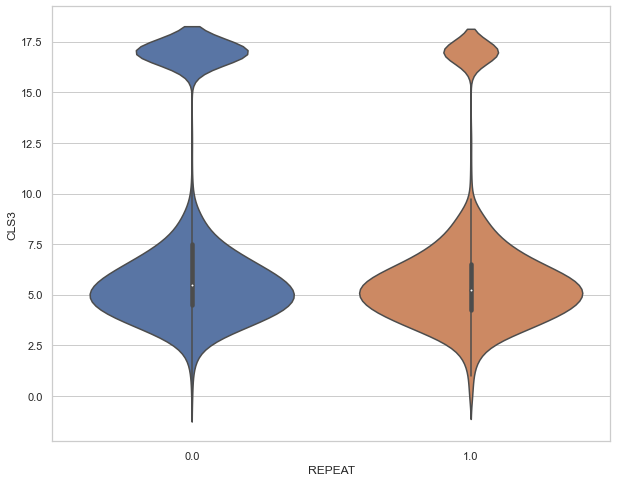

In [75]:
sns.violinplot(x='REPEAT', y='CLS3', data=cls3_r)

#### 2.11 KNLDG

In [76]:
knldg_pd = make_df(df, turn_to_list('304~403'), add_repeat = True)

C:\Users\x\AppData\Local\Temp\ipykernel_2120\4069806483.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new['REPEAT'] = df['REPEAT']


In [77]:
KNLDG = sum(knldg_pd, 'KNLDG', mean=True)

In [78]:
knldg_r = pd.concat([df['REPEAT'], KNLDG], axis=1)

<AxesSubplot:xlabel='REPEAT', ylabel='KNLDG'>

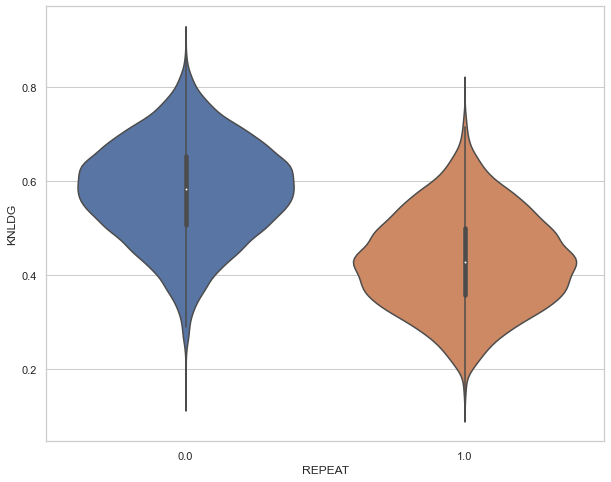

In [79]:
sns.violinplot(x='REPEAT', y='KNLDG', data=knldg_r)

<AxesSubplot:xlabel='KNLDG', ylabel='Count'>

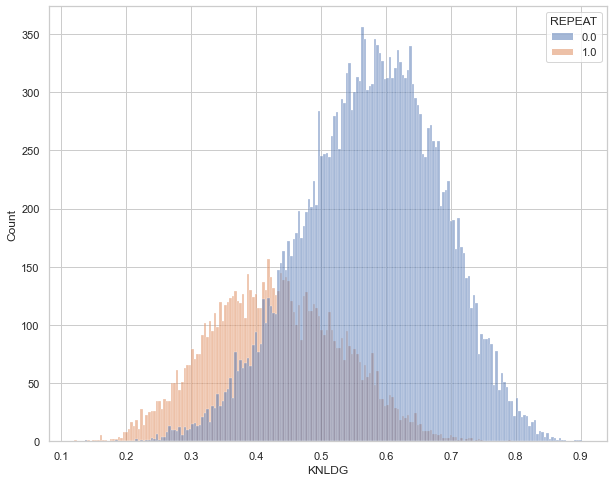

In [80]:
sns.histplot(data = knldg_r, x='KNLDG',bins=200, hue='REPEAT')

## Detailed analysis

Now we have these features:

PRNT_EDU

STDY_EVNRNMNT

LF_QLTY

PRNT_CR

EX_RPT

STY

PEER

TCHR

SKIP

CLS1

CLS2

CLS3

KNLDG

In [81]:
DIY_df = pd.concat([PRNT_EDU, STDY_EVNRNMNT, LF_QLTY, PRNT_CR, EX_RPT, STY, \
    PEER, TCHR, SKIP, CLS1, CLS2, CLS3, KNLDG, df['REPEAT']], axis=1)

In [82]:
DIY_np = MinMaxScaler().fit_transform(DIY_df)
DIY_df = pd.DataFrame(DIY_np, columns=DIY_df.columns)

In [83]:
DIY_df.describe()

,PRNT_EDU,STDY_EVNRNMNT,LF_QLTY,PRNT_CR,EX_RPT,STY,PEER,TCHR,SKIP,CLS1,CLS2,CLS3,KNLDG,REPEAT
count,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000,32130.000000
mean,0.801335,0.186203,0.463214,0.824940,0.091052,0.337768,0.230876,0.180064,0.145323,0.541804,0.570701,0.416041,0.531292,0.284936
std,0.121004,0.167400,0.094141,0.191487,0.158375,0.133531,0.198899,0.194439,0.178514,0.257573,0.227001,0.261666,0.158214,0.451391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.769231,0.000000,0.401709,0.666667,0.000000,0.236842,0.111111,0.000000,0.000000,0.400000,0.444444,0.264706,0.419418,0.000000
50%,0.807692,0.142857,0.461538,0.833333,0.000000,0.342105,0.166667,0.111111,0.111111,0.500000,0.555556,0.323529,0.539985,0.000000
75%,0.884615,0.285714,0.525641,1.000000,0.250000,0.421053,0.333333,0.277778,0.222222,0.650000,0.666667,0.411765,0.648056,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


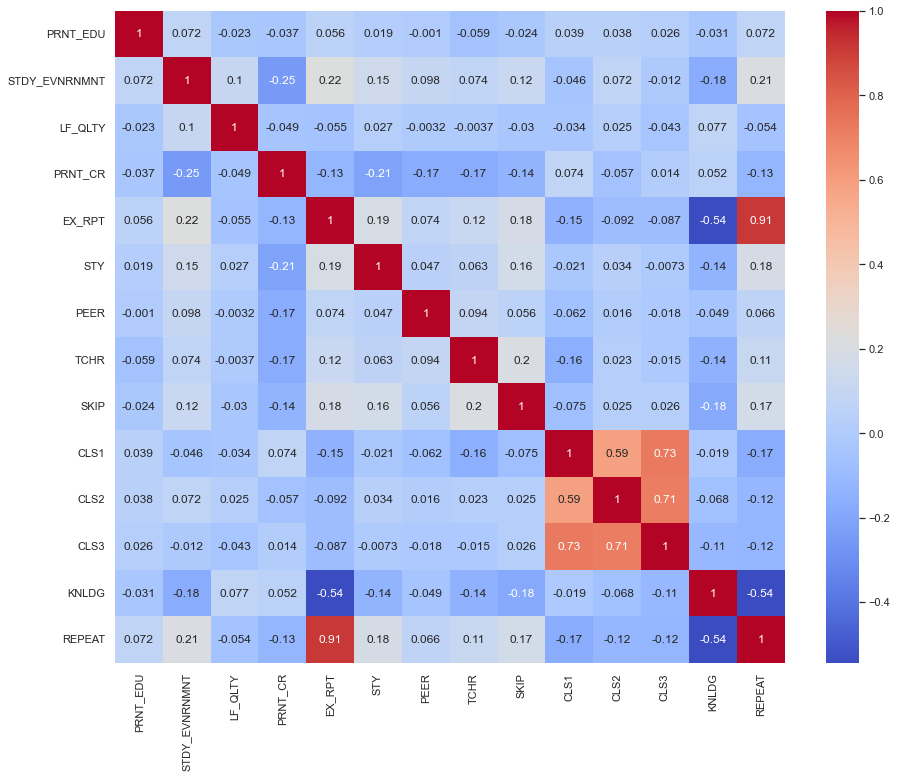

In [84]:
sns.set(rc={'figure.figsize': (15, 12)})  # 设置画板大小
map = draw_corr_map(DIY_df)
sns.set(rc={'figure.figsize': (10, 8)})  # 设置画板大小

We can see that the features in DIY_df has slightly connection, besides (KNLDG,EX_RPT) and (CLS1,CLS2,CLS3). It's easy to understand. If you have poorer knowledge, then you are more likely to repeat your in the past. CLS1,2,3 reveals different parts in school classes, thus they are have strong connection.

Therefore, let's see the relationship between these features and the target `REPEAT`

In [85]:
DIY_df.columns

Index(['PRNT_EDU', 'STDY_EVNRNMNT', 'LF_QLTY', 'PRNT_CR', 'EX_RPT', 'STY',
       'PEER', 'TCHR', 'SKIP', 'CLS1', 'CLS2', 'CLS3', 'KNLDG', 'REPEAT'],
      dtype='object')

In [86]:
# discretize the data
def discrete(df, cond_col, step, tgt_col = 'REPEAT'):
	# min, max = df[cond_col].describe()[3], df[cond_col].describe()[7]
	sum = []
	cur_sum = []
	group = int(1/step)
	for point in np.linspace(0, 1, group+1):
		RPT, total = stat(df, cond_col, point, tgt_col, step)
		cur_sum.append(RPT)
		sum.append(total)
	cur_sum = np.array(cur_sum)
	sum = np.array(sum)
	return cur_sum, sum

In [87]:
# count the total number in the group and the number of repeat in the group
def stat(df, cond_col, base, tgt_col, dur):
	sum = 0.01
	cur_sum = 0
	index = df.index[(base <= df[cond_col]) & (df[cond_col] < base + dur)]
	sub_df = pd.concat([df[cond_col][index], df[tgt_col][index]], axis=1)
	for i in range(sub_df.shape[0]):
		sum += 1
		if sub_df[tgt_col].iloc[i] == 1:
			cur_sum += 1
	return cur_sum, sum

In [88]:
# draw the plot
def plt_discrete(df, cond_col, step, tgt_col = 'REPEAT'):
	cur_sum, sum= discrete(df, cond_col, step, tgt_col)
	x = np.linspace(0, 1, int(1/step)+1)
	y = cur_sum/sum
	itp = interpolate.CubicSpline(x, y)
	xnew = np.linspace(0, 1, 100)
	ynew = itp(xnew)
	plt.plot(xnew, ynew)
	plt.xlabel(cond_col)
	plt.ylabel('probability')
	plt.show()

Let's see some examples of the relationship between my selected feature in `DIY_pd` and the target `REPEAT` 

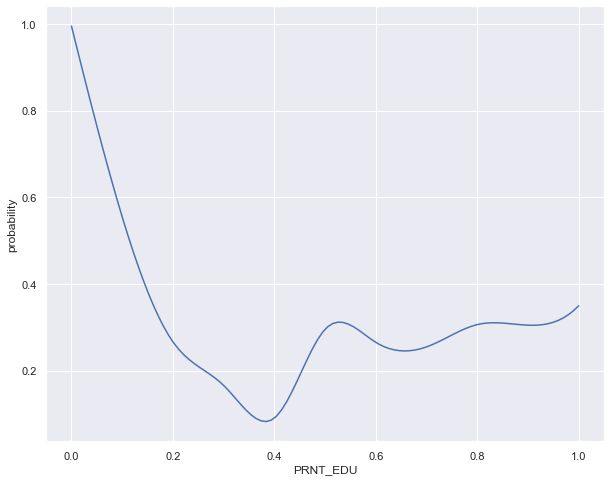

In [89]:
plt_discrete(DIY_df, 'PRNT_EDU', 1/10)

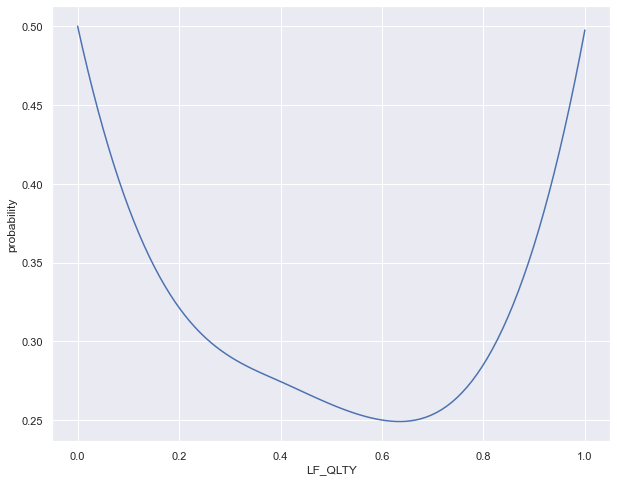

In [90]:
plt_discrete(DIY_df, 'LF_QLTY', 1/5)

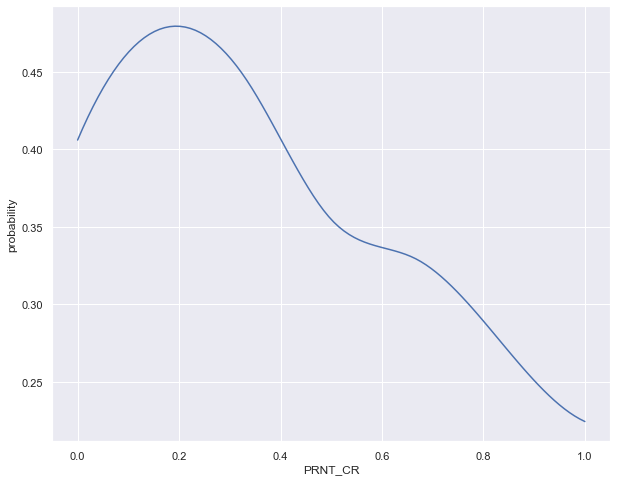

In [91]:
plt_discrete(DIY_df, 'PRNT_CR', 1/6)

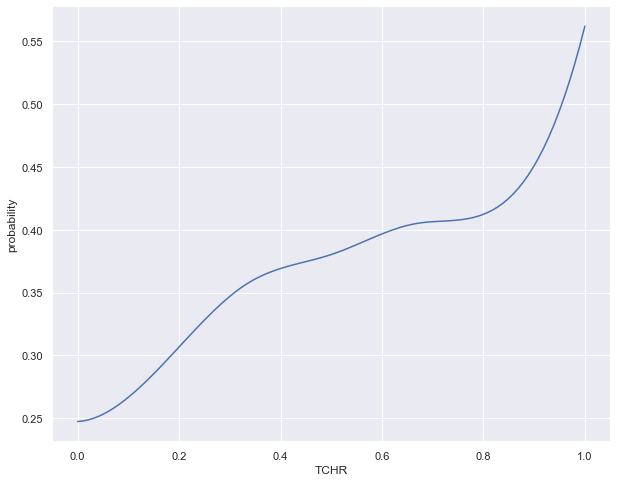

In [92]:
plt_discrete(DIY_df, 'TCHR', 1/6)

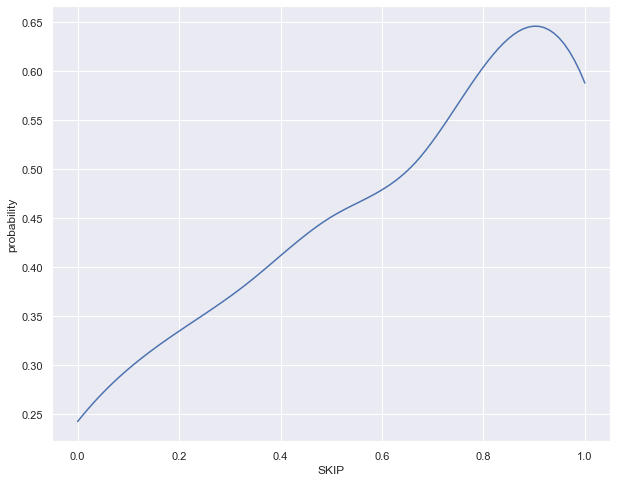

In [93]:
plt_discrete(DIY_df, 'SKIP', 1/6)

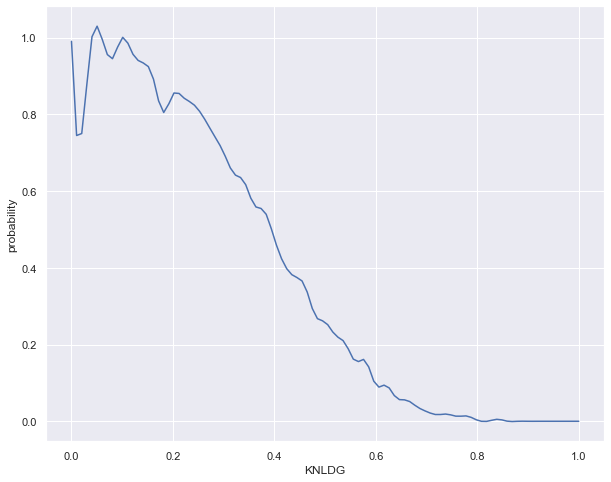

In [94]:
plt_discrete(DIY_df, 'KNLDG', 1/50)